In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")
import sys
sys.path.append('/content/gdrive/My Drive/QRC')

Mounted at /content/gdrive/


In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager 
from matplotlib.pyplot import gca

In [ ]:
from qrc import Pipeline
from qrc.ops import Bridge, separated_measurement_step

In [ ]:
# Number of qubits in reservoirs A and B
n_qubitsA = 3
n_qubitsB = 4
multiplexing = 10
n_qubits_total = n_qubitsA + n_qubitsB

In [ ]:
alpha_purity = [0.4406405 , 1.1309928 , 0.44251928]
rotations_purity = [
         [1.5706338 , 0.25005922, 0.7473237 ],
         [3.1415927 , 0.20195979, 0.7275571 ],
         [1.4890401, 0.3383612, 0.662342 ],
         [1.0503925, 0.2508376, 0.7540839],
        ]

alpha_bridge = [0.21563943, 0.4693331 , 1.0228151 ]
rotations_bridge = [
         [1.0030993, 0.2866138, 1.003308 ],
         [0.88676465, 0.282303  , 0.9138089 ],
         [ 0.86939156, -0.2769101 ,  0.9120728 ],
         [ 0.99995124, -0.28283787,  1.0098064 ],
        ]

In [ ]:
reg = 10**-8
ones = np.ones((200, 1))
reg_eye = reg*np.eye((n_qubits_total) * multiplexing + 1)

def generalization(results, y_true):
    X = results.reshape(-1, (n_qubits_total) * multiplexing)
    X = np.concatenate((X, ones), axis=1)
    X_train = X[:100]
    W = np.linalg.inv(X_train.T @ X_train + reg_eye) @ X_train.T @ y_true
    return X[100:] @ W

def gen_loss(results, signal, offset):
    return np.linalg.norm(generalization(results, signal[1000-offset:1100-offset]) - signal[1100-offset:1200-offset])

In [ ]:
class DefaultBridgePipeline(Pipeline):
    def evaluate_bridge(self, signal, alpha_bridge, rotations_bridge, alpha_purity, rotations_purity, depolarization_prob=0):
        inp = signal[1000:1200]
        result = np.zeros((len(inp), self.multiplexing, self.n_qubits_total))
        purification_queue = self.get_purification_queue()
        state = self.init_state
        self.bridge.set_bridge_unitary(alpha_bridge, rotations_bridge)
        self.purifier.set_anzatz_unitary_list(alpha_purity, rotations_purity)

        for i in range(1000):
            state = self.encoder.encoding_step(state, signal[i])
            state = self.evolution_step(state)
            state = self.bridge.entangled_channel_step(state)
            state = self.depolarization_step(state, depolarization_prob)
            if i % 2 == 0 and i != 0:
                state = self.evolution_step(state)
                site = next(purification_queue)
                state = self.purifier.purification_step(state, site)

        for n in range(len(inp)):
            state = self.encoder.encoding_step(state, inp[n])
            state = self.evolution_step(state)
            state = self.bridge.entangled_channel_step(state)
            state = self.depolarization_step(state, depolarization_prob)

            for m in range(self.multiplexing):
                state = self.evolution_step(state)
                if m % 5 == 0:
                    site = next(purification_queue)
                    state = self.purifier.purification_step(state, site)

                for site in range(self.n_qubits_total):
                    state, outcome = separated_measurement_step(state, site, self.n_qubits_total)
                    result[n, m, site] = outcome

        return result

In [ ]:
timesteps = np.linspace(0.1, 0.6, 25)

In [ ]:
losses = []
vars = []
for t in timesteps:
    print(t)
    pipeline = DefaultBridgePipeline(n_qubitsA, n_qubitsB, t, multiplexing)
    loss = []
    for _ in tqdm(range(25)):
        signal = np.random.choice(2, size=1200)
        res = pipeline.evaluate_bridge(signal, alpha_bridge, rotations_bridge, alpha_purity, rotations_purity, depolarization_prob=0)
        loss.append(gen_loss(res, signal, 10))
    losses.append(np.mean(loss))
    vars.append(np.var(loss))
np.save('/content/gdrive/My Drive/QRC/ArticleProduction/Data/Timesteps/LOSSES_34.npy', losses)
np.save('/content/gdrive/My Drive/QRC/ArticleProduction/Data/Timesteps/VARS_34.npy', vars)

0.1


  0%|          | 0/25 [00:00<?, ?it/s]

0.12083333333333333


  0%|          | 0/25 [00:00<?, ?it/s]

0.14166666666666666


  0%|          | 0/25 [00:00<?, ?it/s]

0.1625


  0%|          | 0/25 [00:00<?, ?it/s]

0.18333333333333335


  0%|          | 0/25 [00:00<?, ?it/s]

0.20416666666666666


  0%|          | 0/25 [00:00<?, ?it/s]

0.225


  0%|          | 0/25 [00:00<?, ?it/s]

0.24583333333333332


  0%|          | 0/25 [00:00<?, ?it/s]

0.26666666666666666


  0%|          | 0/25 [00:00<?, ?it/s]

0.2875


  0%|          | 0/25 [00:00<?, ?it/s]

0.30833333333333335


  0%|          | 0/25 [00:00<?, ?it/s]

0.32916666666666666


  0%|          | 0/25 [00:00<?, ?it/s]

0.35


  0%|          | 0/25 [00:00<?, ?it/s]

0.37083333333333335


  0%|          | 0/25 [00:00<?, ?it/s]

0.3916666666666666


  0%|          | 0/25 [00:00<?, ?it/s]

0.4125


  0%|          | 0/25 [00:00<?, ?it/s]

0.43333333333333335


  0%|          | 0/25 [00:00<?, ?it/s]

0.4541666666666666


  0%|          | 0/25 [00:00<?, ?it/s]

0.475


  0%|          | 0/25 [00:00<?, ?it/s]

0.49583333333333335


  0%|          | 0/25 [00:00<?, ?it/s]

0.5166666666666666


  0%|          | 0/25 [00:00<?, ?it/s]

0.5375


  0%|          | 0/25 [00:00<?, ?it/s]

0.5583333333333333


  0%|          | 0/25 [00:00<?, ?it/s]

0.5791666666666666


  0%|          | 0/25 [00:00<?, ?it/s]

0.6


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  """


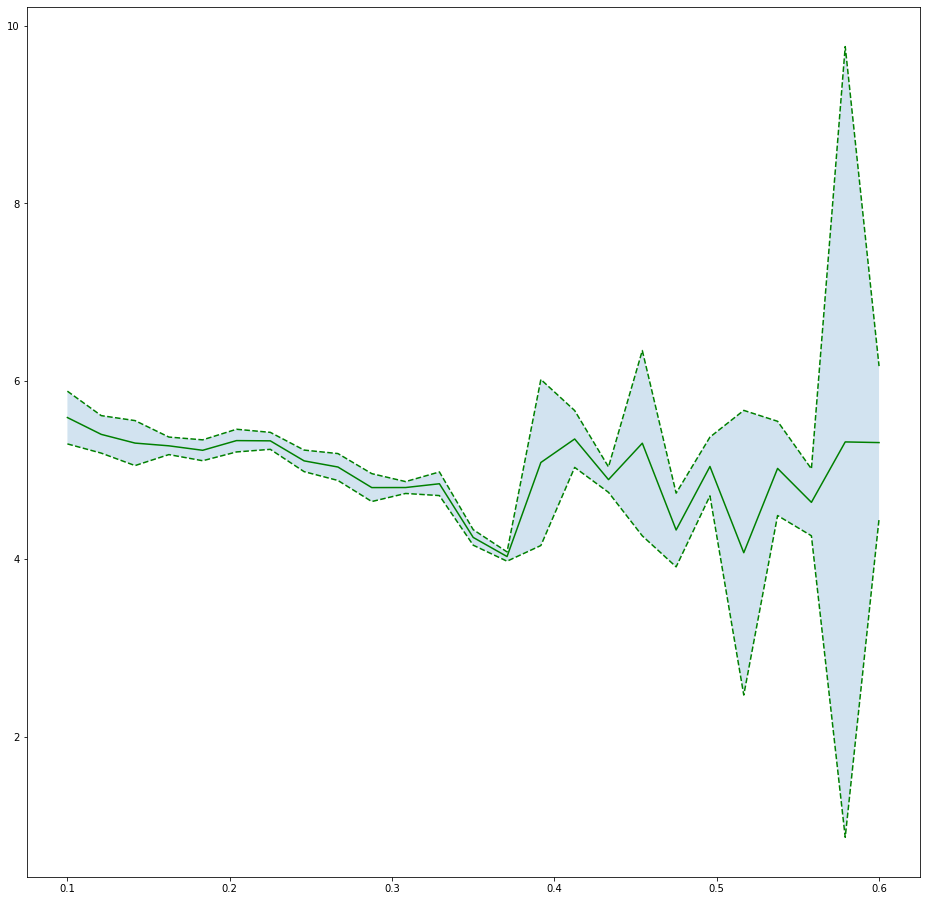

In [ ]:
plt.figure(figsize=(16,16))
mean = np.array(losses)
std = np.array(vars)
plt.plot(timesteps, mean, 'g')
plt.fill_between(timesteps, mean - std, mean + std, 'g', alpha=0.2)
plt.plot(timesteps, mean - std, 'g--')
plt.plot(timesteps, mean + std, 'g--')